In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as K
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-04-16 12:43:25.066519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with h5py.File("info/data/output_signal.h5", "r") as file:
    signal_data = file["events"][:]

with h5py.File("info/data/output_bg.h5", "r") as file:
    bg_data = file["events"][:]

# Loading the Data

In [3]:
# storing signal and background data in panda DataFrame
signal = pd.DataFrame(signal_data)
background = pd.DataFrame(bg_data)

# concatenating the data frames to be part of one big set
df = pd.concat([signal, background])

# reseting the indicies
df = df.reset_index()

# creating the labels for the data sets i.e; signal = 1, background = 0 for classification
labels = np.concatenate([np.ones(signal.shape[0]), np.zeros(background.shape[0])])
labels = pd.DataFrame({'ttZ': labels})

# adding labels as a column at the end of the DataFrame
df = df.join(labels)

# shuffling the DataFrame
df_shuffled = df.sample(frac=1, random_state=42)  # 'random_state' for reproducibility
df_shuffled.head()

# splitting the labels from the rest of the dataset
y = df_shuffled['ttZ']

# we can check the class distribution in the subset
print('ttZ events: {:.2f}%'.format(np.sum(y)/len(y) * 100))
print('WZ events: {:.2f}%'.format((1 - np.sum(y)/len(y)) * 100))

ttZ events: 68.65%
WZ events: 31.35%


# Various Feature Lists

In [4]:
# base input list suggested by the project
input_list = [ "H_T",
              "jet_1_pt",
              "jet_2_pt",
              "lep_1_pt",
              "lep_2_pt",
              "n_bjets",
              "jet_1_twb",
              "jet_2_twb",
              "bjet_1_pt"]

# best input list suggested by SRS 
input_list_2 = ['jet_1_pt', 
                'jet_3_pt', 
                'jet_1_eta', 
                'jet_3_eta', 
                'jet_1_twb', 
                'jet_2_twb', 
                'jet_3_twb', 
                'bjet_1_pt', 
                'n_jets', 
                'n_bjets',
                'n_leptons']

# smallest input list that still has an accuracy >80%, suggested by SRS
input_list_3 = ['jet_3_pt',
                'jet_1_twb',
                'jet_2_twb',
                'jet_3_twb',
                'bjet_1_pt',
                'n_jets',
                'n_bjets']

input_lists = [input_list, input_list_2, input_list_3]

# Running Base Model for all Feature Lists

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 hidden1 (Dense)             (None, 50)                500       
                                                                 
 hidden2 (Dense)             (None, 25)                1275      
                                                                 
 hidden3 (Dense)             (None, 10)                260       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 2,065
Trainable params: 2,046
Non-trainable params: 19
_____________________________________________________

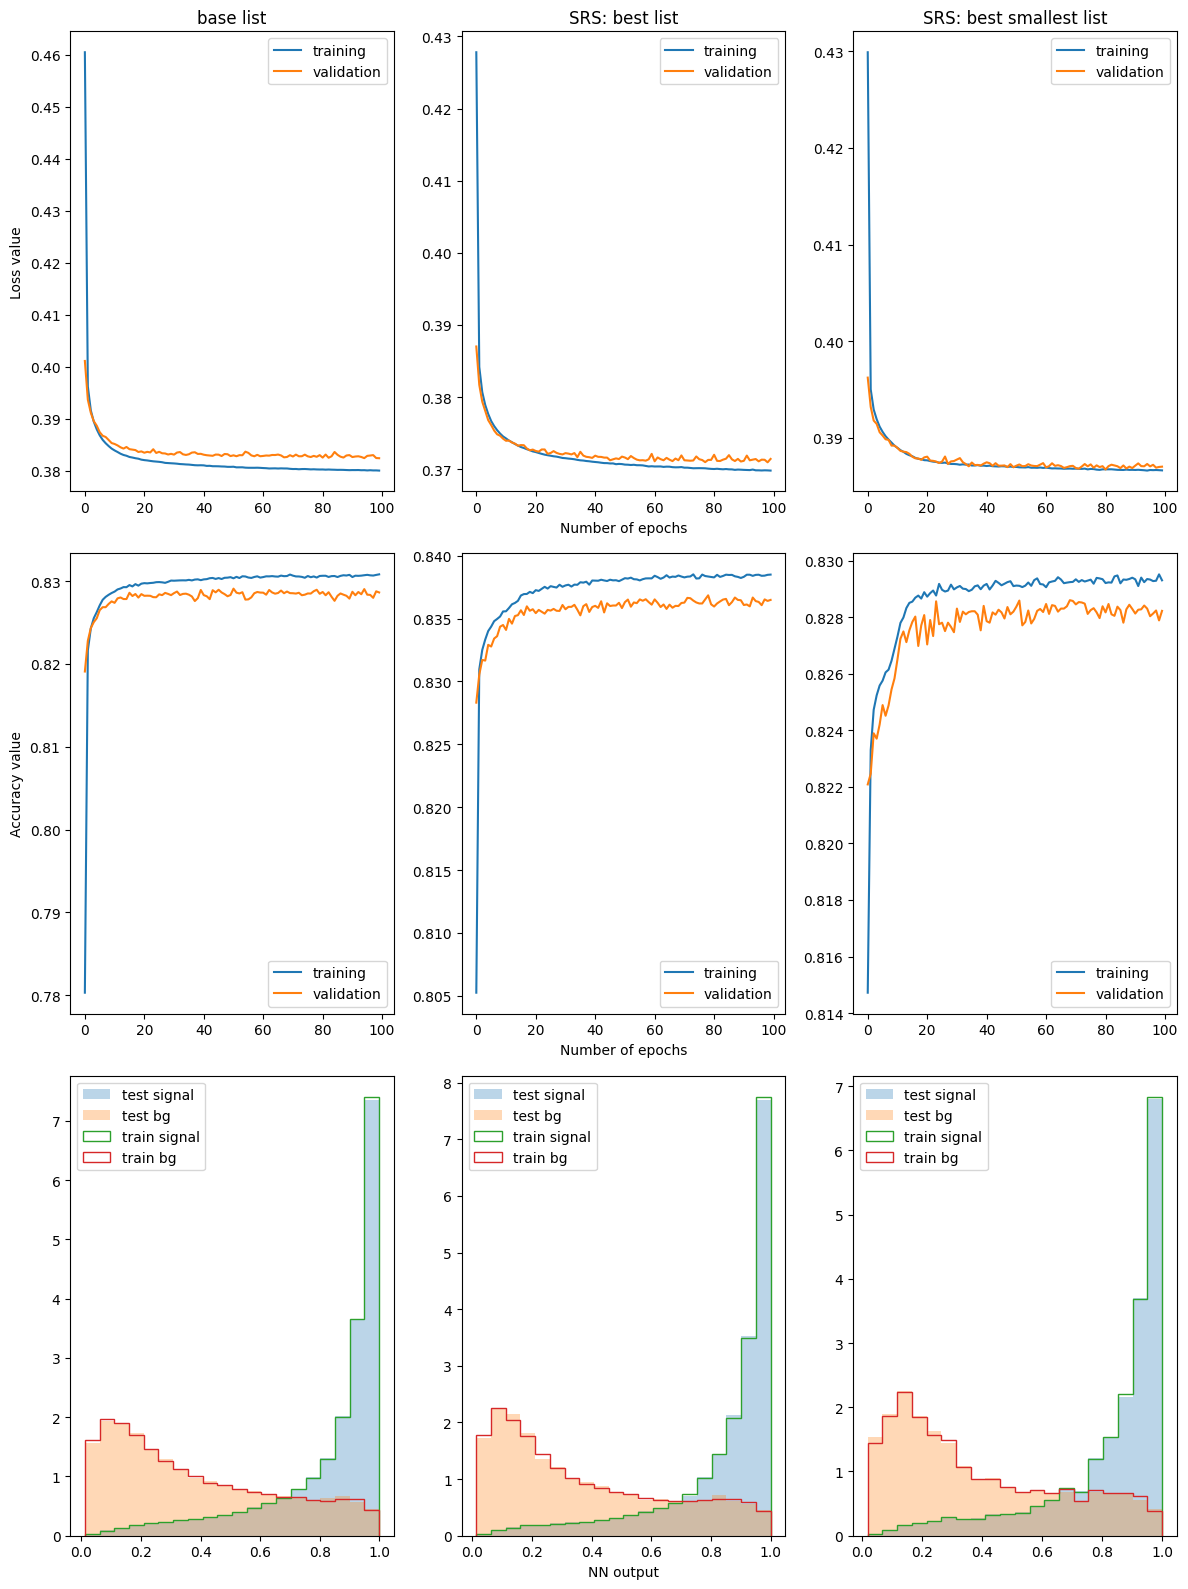

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(12, 16))

for i, feature_list in enumerate(input_lists):
    names = ['base list', 'SRS: best list', 'SRS: best smallest list']
    X = df_shuffled[feature_list]
    x_train, x_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)
    x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, train_size=0.5)

    preprocessing_layer = K.layers.Normalization()
    preprocessing_layer.adapt(x_train)

    model = K.Sequential(
    [
        preprocessing_layer,
        K.layers.Dense(50, activation="relu", name="hidden1"),
        K.layers.Dense(25, activation="relu", name="hidden2"),
        K.layers.Dense(10, activation="relu", name="hidden3"),
        K.layers.Dense(1, activation="sigmoid", name="output"),
    ]
    )

    model.summary()

    model.compile(optimizer=K.optimizers.Adam(learning_rate=0.0002), 
                  loss=K.losses.BinaryCrossentropy(), 
                  metrics=[K.metrics.BinaryAccuracy()])
    
    fit_history = model.fit(
        x_train,
        y_train,
        batch_size=512,
        epochs=100,
        validation_data=(x_val, y_val),
        verbose = 0)

    
    print("Printing summary of the trained model:")
    print(model.summary())

    axs[0, i].plot(fit_history.history["loss"], label="training")
    axs[0, i].plot(fit_history.history["val_loss"], label="validation")
    axs[0, i].legend()
    axs[0, i].set_title(names[i])

    axs[1, i].plot(fit_history.history["binary_accuracy"], label="training")
    axs[1, i].plot(fit_history.history["val_binary_accuracy"], label="validation") 
    axs[1, i].legend()

    _, bins, _ = axs[2, i].hist(model.predict(x_test[y_test.astype(bool)]), bins=20, alpha=0.3, density=True, label="test signal")
    axs[2, i].hist(model.predict(x_test[~y_test.astype(bool)]), bins=bins, alpha=0.3, density=True, label="test bg")
    axs[2, i].hist(model.predict(x_train[y_train.astype(bool)]), bins=bins, density=True, histtype="step", label="train signal")
    axs[2, i].hist(model.predict(x_train[~y_train.astype(bool)]), bins=bins, density=True, histtype="step", label="train bg")
    axs[2, i].legend()

    if i == 0:
            axs[0, i].set_ylabel("Loss value")
            axs[1, i].set_ylabel("Accuracy value")
            
    elif i == 1:
        axs[0, i].set_xlabel("Number of epochs")
        axs[1, i].set_xlabel("Number of epochs")
        axs[2, i].set_xlabel("NN output")

fig.tight_layout()
plt.savefig("feat-comparison.pdf")
plt.show()